<a href="https://colab.research.google.com/github/Maithraanand/Applied-DL/blob/main/Sparse_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
andrewmvd_helmet_detection_path = kagglehub.dataset_download('andrewmvd/helmet-detection')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/helmet-detection'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/helmet-detection/annotations/BikesHelmets338.xml
/kaggle/input/helmet-detection/annotations/BikesHelmets680.xml
/kaggle/input/helmet-detection/annotations/BikesHelmets62.xml
/kaggle/input/helmet-detection/annotations/BikesHelmets172.xml
/kaggle/input/helmet-detection/annotations/BikesHelmets622.xml
/kaggle/input/helmet-detection/annotations/BikesHelmets477.xml
/kaggle/input/helmet-detection/annotations/BikesHelmets488.xml
/kaggle/input/helmet-detection/annotations/BikesHelmets696.xml
/kaggle/input/helmet-detection/annotations/BikesHelmets71.xml
/kaggle/input/helmet-detection/annotations/BikesHelmets269.xml
/kaggle/input/helmet-detection/annotations/BikesHelmets206.xml
/kaggle/input/helmet-detection/annotations/BikesHelmets705.xml
/kaggle/input/helmet-detection/annotations/BikesHelmets515.xml
/kaggle/input/helmet-detection/annotations/BikesHelmets113.xml
/kaggle/input/helmet-detection/annotations/BikesHelmets546.xml
/kaggle/input/helmet-detection/annotations/BikesHelmets63

Epoch 1/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 849ms/step - loss: 0.6930 - val_loss: 0.6738
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 839ms/step - loss: 0.6714 - val_loss: 0.6486
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 811ms/step - loss: 0.6474 - val_loss: 0.6275
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 797ms/step - loss: 0.6277 - val_loss: 0.6166
Epoch 5/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 824ms/step - loss: 0.6180 - val_loss: 0.6074
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 848ms/step - loss: 0.6102 - val_loss: 0.6015
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 793ms/step - loss: 0.6065 - val_loss: 0.6018
Epoch 8/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 803ms/step - loss: 0.6050 - val_loss: 0.5955
Epoch 9/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 815ms/step - loss: 0.6051 - val_loss: 0.5925
Epoch 10/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 867ms/step - loss: 0.6020 - val_loss: 0.5972
Epoch 11/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 797ms/step - loss: 0.6002 - val_loss: 0.5913
Epoch 12/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 808ms/st

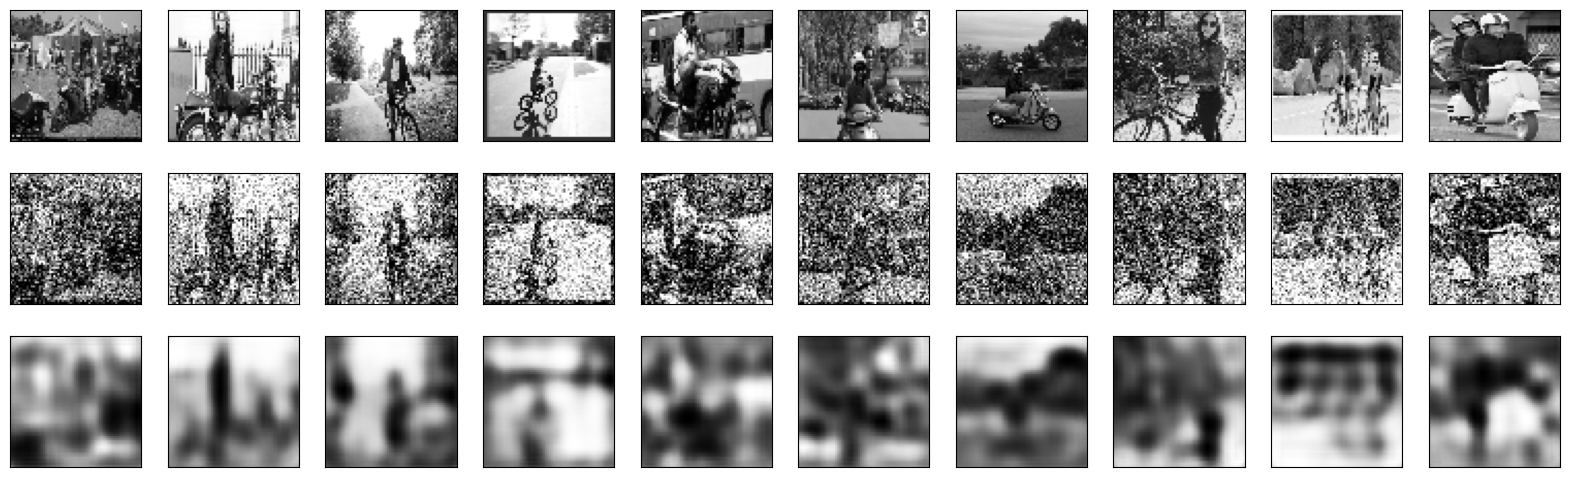

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

# Set image dimensions
IMG_SIZE = 64  # Resize images to 64x64
DATASET_PATH = "/kaggle/input/helmet-detection/images"  # Path to images folder

# Load images
def load_images_from_folder(folder, img_size):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = load_img(img_path, target_size=(img_size, img_size), color_mode="grayscale")  # Convert to grayscale
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        images.append(img_array)
    return np.array(images)

# Load and preprocess images
x_data = load_images_from_folder(DATASET_PATH, IMG_SIZE)
x_data = x_data.reshape(-1, IMG_SIZE, IMG_SIZE, 1)  # Keep 4D shape (batch, height, width, channels)

# Split into train and test sets
x_train, x_test = train_test_split(x_data, test_size=0.2, random_state=42)

# Add noise to images
noise_factor = 0.3  # Reduce noise factor to maintain clarity
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# Define the CNN-based autoencoder architecture
input_img = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 1))

# Encoder
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

encoded = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)

# Decoder
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = tf.keras.layers.UpSampling2D((2, 2))(x)

x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)

x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)

decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Compile the model
autoencoder = tf.keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the autoencoder
autoencoder.fit(x_train_noisy, x_train,
                epochs=15,  # Increased epochs
                batch_size=64,  # Smaller batch size for better updates
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

# Predict denoised images
decoded_imgs = autoencoder.predict(x_test_noisy)

# Display original, noisy, and reconstructed images
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(decoded_imgs[i].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()
